In [1]:
import numpy
import tqdm
import pandas
import conntility
import json
import connalysis
import os

from scipy.spatial import KDTree

from matplotlib import pyplot as plt

from scipy import sparse
from scipy.spatial.distance import pdist, squareform

import nngraphmdl

In [2]:
dims = numpy.array([700, 700, 700])
N = [5000, 500, 50]
P = [[0.15, 0.5, 0.0],
     [0.2, 0.15, 0.5],
     [0.0, 0.2, 0.15]]
L = [[5, 1, 1],
     [5, 5, 1],
     [1, 5, 5]]

def make_points(dims, n):
    return numpy.random.rand(n, 3) * dims.reshape((1, -1)) - (dims/2).reshape((1, -1))

pts = [make_points(dims, _N) for _N in N]

def make_matrix_row(pts, level_fr, P, L, K=None, mirror=False):
    if K is None:
        K = [None for _ in L[level_fr]]
    else:
        K = K[level_fr]
    Ms = [
        nngraphmdl.model.point_nn_matrix(_pts, lambda a: a.apply(lambda _a: P[level_fr][_i]),
                                         pts_x=pts[level_fr], n_neighbors=L[level_fr][_i],
                                         n_pick=K[_i], mirror=mirror)
        if numpy.abs(_i - level_fr) <= 1
        else sparse.coo_matrix(([], ([], [])), shape=(len(pts[level_fr]), len(_pts))).tocsc()
        for _i, _pts in enumerate(pts)
    ]
    return sparse.hstack(Ms)

def make_full_matrix(pts, P, L, K=None, mirror=False):
    return sparse.vstack([
        make_matrix_row(pts, _i, P, L, K=K, mirror=mirror)
        for _i in range(len(pts))
    ])

M = make_full_matrix(pts, P, L)
D = squareform(pdist(pts[0]))
nbins = 31
dbins = numpy.linspace(0.01, D.max(), nbins)

In [5]:
def build_instance(pts, M, n_steps, sum_exclusion=True, step_tgt=10, n_protected=0):
    exclusion = sparse.coo_matrix(([], ([], [])), shape=M.shape)

    initial = sparse.coo_matrix((numpy.ones(len(pts[0])),
                                (numpy.arange(len(pts[0])), numpy.arange(len(pts[0])))),
                                shape=M.shape).tocsr()

    row = []
    col = []
    data = []
    l = numpy.cumsum([0] + [len(_pts) for _pts in pts])

    state = initial
    history = []
    M = M.transpose()

    for _step in range(n_steps):
        candidates = state * M - 100 * (exclusion + initial)
        candidates.data = numpy.minimum(numpy.maximum(candidates.data, 0), 1.0)
        #fac = step_tgt / candidates.sum(axis=1).mean()
        fac = step_tgt / numpy.array(candidates.sum(axis=1) + 1E-3)[:, 0]
        #currsum = numpy.array(candidates.sum(axis=1))[:, 0]
        #fac = numpy.minimum(numpy.exp(-(currsum/step_tgt - 1)), 1.0)
        # candidates = fac * candidates
        #adjust = numpy.minimum(numpy.exp(-(currsum/lim - 1)), 1.0)
        new_state = nngraphmdl.model.evaluate_probs(candidates, adjust=fac, less_random=(_step < n_protected))

        row.extend(new_state.row); col.extend(new_state.col); data.extend(_step * numpy.ones(new_state.nnz, dtype=int))
        new_state = new_state.tocsr()

        h_i = [new_state[:, a:b].sum(axis=1).mean()
               for a, b in zip(l[:-1], l[1:])]  # Mean number added per original neuron
        history.append(h_i)
        if sum_exclusion:
            exclusion = exclusion + state
        else:
            exclusion = state
        state = new_state


    full_instance = sparse.coo_matrix((
        numpy.ones(len(row), dtype=bool),
        (row, col)
    ), shape=M.shape).tocsr()

    l = numpy.cumsum([0] + [len(_pts) for _pts in pts])
    degs = [numpy.array(full_instance[:, a:b].sum(axis=1))[:, 0]
            for a, b in zip(l[:-1], l[1:])]
    degs = pandas.DataFrame(degs).transpose()
    instance = full_instance[:, :len(pts[0])][:len(pts[0])]
    return instance, history, degs

In [6]:
def draw_instance_distance_dependence(instance, D, ax=None):
    Ncoo = instance.tocoo()

    H_all = numpy.histogram(D.flatten(), bins=dbins)[0]
    H_con_mdl = numpy.histogram(D[Ncoo.row, Ncoo.col], bins=dbins)[0]

    if ax is None:
        fig = plt.figure()
        ax = fig.gca()
    ax.plot(dbins[:-1], H_con_mdl / H_all, label="Model")
    plt.gca().set_yscale("log")
    ax.set_xlabel("Distance (um)"); ax.set_ylabel("P")
    plt.legend()
    return ax

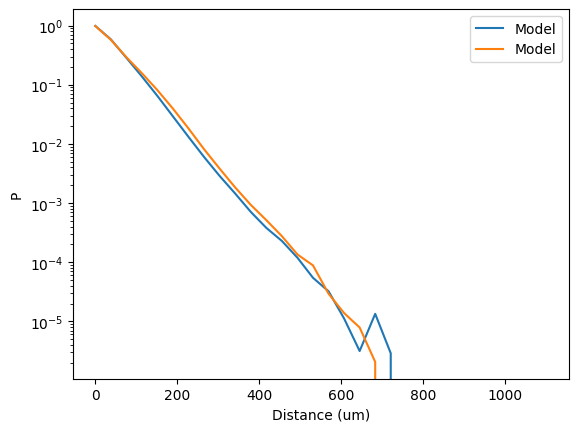

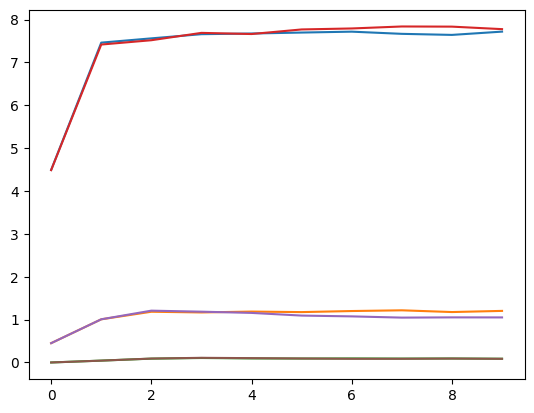

In [7]:
instance1, h1, instance1_f = build_instance(pts, M, 10, sum_exclusion=False)
instance2, h2, instance2_f = build_instance(pts, M, 10, sum_exclusion=True)

ax = draw_instance_distance_dependence(instance1, D)
ax = draw_instance_distance_dependence(instance2, D, ax=ax)

ax = plt.figure().gca()

ax.plot(h1)
ax.plot(h2)

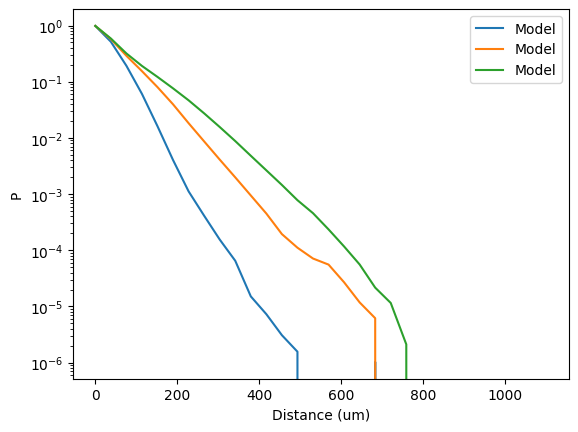

In [8]:
instance1, h1, degs1 = build_instance(pts, M, 5, sum_exclusion=True)
instance2, h2, degs2 = build_instance(pts, M, 10, sum_exclusion=True)
instance3, h3, degs3 = build_instance(pts, M, 15, sum_exclusion=True)

ax = draw_instance_distance_dependence(instance1, D)
ax = draw_instance_distance_dependence(instance2, D, ax=ax)
ax = draw_instance_distance_dependence(instance3, D, ax=ax)

In [9]:
def instance_distance_dependence(instance, D, dbins):
    Ncoo = instance.tocoo()

    H_all = numpy.histogram(D.flatten(), bins=dbins)[0]
    H_con_mdl = numpy.histogram(D[Ncoo.row, Ncoo.col], bins=dbins)[0]
    p = H_con_mdl / H_all
    p0 = p[0]
    pttl = instance.nnz / numpy.prod(instance.shape)
    v = (p > 0)
    pslope = numpy.polyfit(dbins[1:][v], numpy.log10(p[v]), 1)[0]
    return pandas.Series({"p0": p0, "pttl": pttl, "slope": pslope})

In [10]:
N = [10000, 1000]
dims = numpy.array([600, 600, 600])
pts = [make_points(dims, _N) for _N in N]

D = squareform(pdist(pts[0]))
nbins = 21
dbins = numpy.linspace(0.01, D.max(), nbins)

def make_P(p_i, p_up, p_down):
    P = [[p_i, p_up],
        [p_down, p_i]]
    return P

def make_L(l_i, l_up, l_down):
    L = [[l_i, l_up],
        [l_down, l_i]]
    return L

def instance_from_parameters(pts, p_i, p_up, p_down,
                             l_i, l_up, l_down, 
                             n_steps, sum_exclusion):
    P = make_P(p_i, p_up, p_down)
    L = make_L(l_i, l_up, l_down)
    M = make_full_matrix(pts, P, L)
    return build_instance(pts, M, n_steps, sum_exclusion=sum_exclusion)

def evaluate_from_parameters(*args):
    print(args[1:])
    I, _, _ = instance_from_parameters(*args)
    return instance_distance_dependence(I, D, dbins)

lst_params = [pandas.Series([0.4, 0.5, 0.6], name="p_up"),
            pandas.Series([0.08, 0.1, 0.12], name="p_i"),
            pandas.Series([0.5], name="p_down"),
            pandas.Series([5], name="l_i"),
            pandas.Series([1], name="l_up"),
            pandas.Series([5], name="l_down"),
            pandas.Series([10], name="n_steps"),
            pandas.Series([True], name="sum_exclusion")]


In [9]:
def recursive(to_add, df):
    if len(to_add) == 0:
        return df
    if df is None:
        return recursive(to_add[1:], pandas.DataFrame({to_add[0].name: to_add[0].values}))
    out = []
    for val in to_add[0].values:
        _df = df.copy()
        _df[to_add[0].name] = val
        out.append(_df)
    return recursive(to_add[1:], pandas.concat(out, axis=0).reset_index(drop=True))

all_params = recursive(lst_params, None)

res = all_params.apply(lambda row: evaluate_from_parameters(pts, row["p_i"], row["p_up"], row["p_down"],
                                                            row["l_i"], row["l_up"], row["l_down"],
                                                            row["n_steps"], row["sum_exclusion"]),
                 axis=1)
res.index = pandas.MultiIndex.from_frame(all_params)
res


(0.08, 0.4, 0.5, 5, 1, 5, 10, True)
(0.08, 0.5, 0.5, 5, 1, 5, 10, True)
(0.08, 0.6, 0.5, 5, 1, 5, 10, True)
(0.1, 0.4, 0.5, 5, 1, 5, 10, True)
(0.1, 0.5, 0.5, 5, 1, 5, 10, True)
(0.1, 0.6, 0.5, 5, 1, 5, 10, True)
(0.12, 0.4, 0.5, 5, 1, 5, 10, True)
(0.12, 0.5, 0.5, 5, 1, 5, 10, True)
(0.12, 0.6, 0.5, 5, 1, 5, 10, True)


,,,,,,,,p0,pttl,slope
p_up,p_i,p_down,l_i,l_up,l_down,n_steps,sum_exclusion,,,
0.4,0.08,0.5,5,1,5,10,True,0.584169,0.006795,-0.018409
0.5,0.08,0.5,5,1,5,10,True,0.588624,0.006822,-0.016911
0.6,0.08,0.5,5,1,5,10,True,0.589777,0.006828,-0.018558
0.4,0.10,0.5,5,1,5,10,True,0.596027,0.006858,-0.017358
0.5,0.10,0.5,5,1,5,10,True,0.596410,0.006904,-0.016776
0.6,0.10,0.5,5,1,5,10,True,0.598181,0.006929,-0.019178
0.4,0.12,0.5,5,1,5,10,True,0.601662,0.006920,-0.018649
0.5,0.12,0.5,5,1,5,10,True,0.602779,0.006966,-0.018732
0.6,0.12,0.5,5,1,5,10,True,0.604769,0.006971,-0.019350


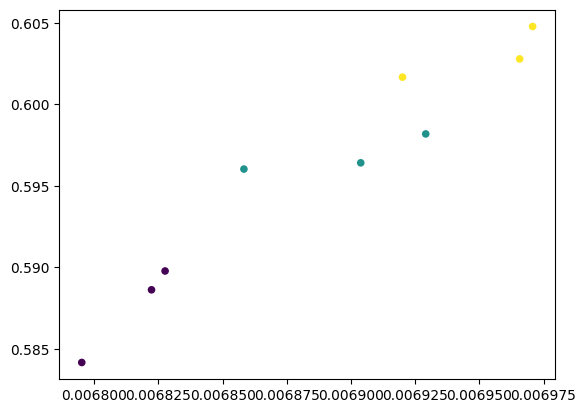

In [11]:
_res = res.reset_index()
plt.scatter(_res["pttl"], _res["p0"], c=_res["p_i"], s=20)

p0       0.285015
pttl     0.006279
slope   -0.006654
dtype: float64


/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_89670/495729018.py:22: RuntimeWarning: invalid value encountered in divide
  return H_x_con / H_x_all


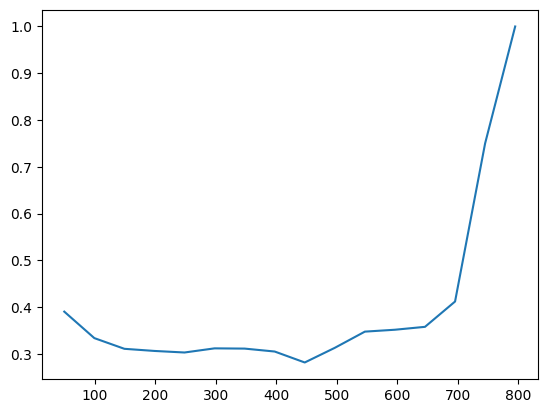

In [11]:
def dist_and_nn_analysis(matrix, pts, D, dbins, direction="efferent"):
    if direction == "efferent":
        O = matrix.tocsr()
    elif direction == "afferent":
        O = matrix.tocsc()

    kd = KDTree(pts)
    _, idx = kd.query(pts, numpy.arange(2, 3))
    idx = idx[:, 0]

    dists_x_all = []; dists_x_con = []
    for i, ab in enumerate(zip(O.indptr[:-1], O.indptr[1:])):
        a, b = ab
        __idx = O.indices[a:b]
        nn_idx = idx[__idx]  # indices of neurons that have their nearest neighbor being connected
        is_con = numpy.in1d(nn_idx, __idx)
        _d = D[i, nn_idx]
        dists_x_all.extend(_d)  # distances of neurons that have their nn connected
        dists_x_con.extend(_d[is_con])  # distances of neurons that have their nn connected and themselves connected
    H_x_all = numpy.histogram(dists_x_all, bins=dbins)[0]
    H_x_con = numpy.histogram(dists_x_con, bins=dbins)[0]
    return H_x_con / H_x_all

# P = [[0.25, 0.65],
#      [0.2, 0.5]]
# L = [[5, 2],
#      [5, 5]]
P = [[0.15, 1.],
     [1., 0.6]]
L = [[30, 1],
     [1, 5]]
K = [[15, None],
     [None, None]]

N = [10000, 350]
dims = numpy.array([600, 600, 600])
pts = [make_points(dims, _N) for _N in N]

D = squareform(pdist(pts[0]))
nbins = 21
dbins = numpy.linspace(0.01, D.max(), nbins)

M = make_full_matrix(pts, P, L, K=K)
instance1, a, b = build_instance(pts, M, 100, step_tgt=2.65, sum_exclusion=False, n_protected=10)
print(instance_distance_dependence(instance1, D, dbins))
plt.plot(dbins[1:], dist_and_nn_analysis(instance1, pts[0], D, dbins, direction="efferent"))

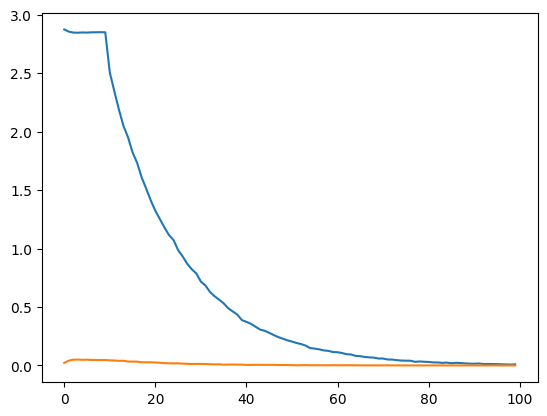

In [12]:
a = numpy.array(a)
plt.plot(a)

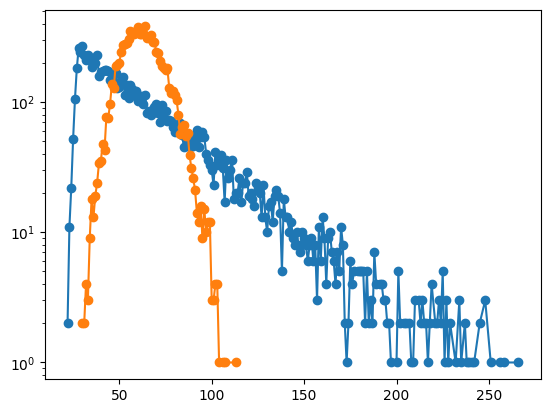

In [13]:
rc = pandas.DataFrame({"row": instance1.tocoo().row,
                       "col": instance1.tocoo().col})
plt.plot(rc["row"].value_counts().value_counts().sort_index(), marker='o')
plt.plot(rc["col"].value_counts().value_counts().sort_index(), marker='o')
plt.gca().set_yscale("log")

<Axes: xlabel='Distance (um)', ylabel='P'>

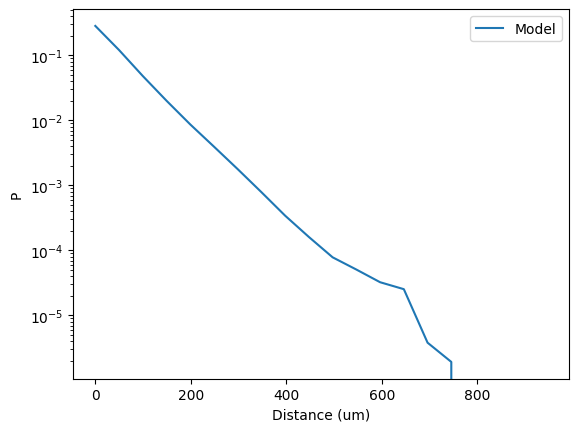

In [14]:
draw_instance_distance_dependence(instance1, D)

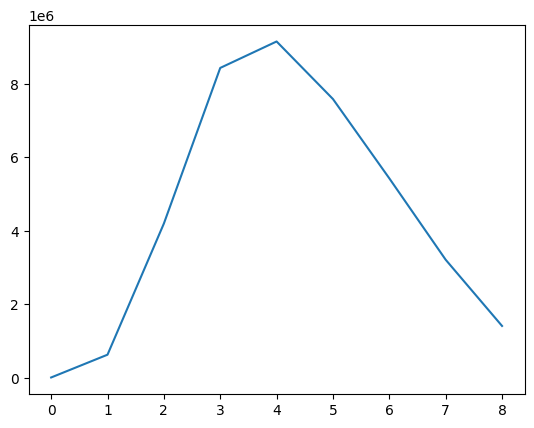

In [16]:
plt.plot(connalysis.network.topology.simplex_counts(instance1, max_dim=8))

p0       0.160347
pttl     0.004662
slope   -0.005555
dtype: float64


/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_89670/495729018.py:22: RuntimeWarning: invalid value encountered in divide
  return H_x_con / H_x_all


<Axes: xlabel='Distance (um)', ylabel='P'>

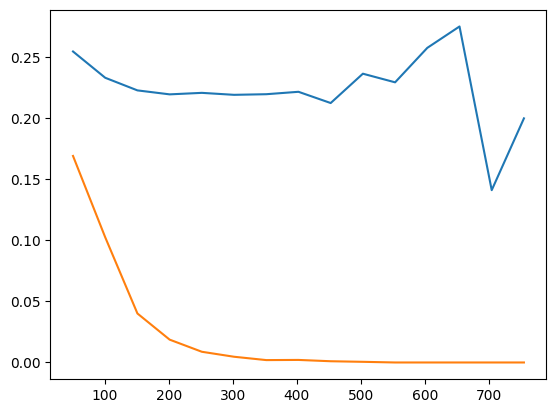

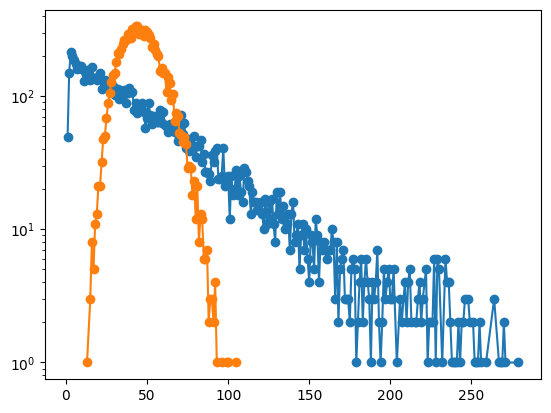

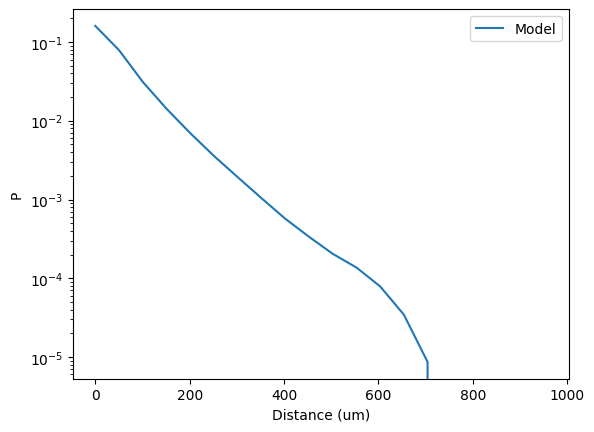

In [15]:
P = [[0.1]]
L = [[50]]
K = [[4]]

N = [10000]
dims = numpy.array([600, 600, 600])
pts = [make_points(dims, _N) for _N in N]

D = squareform(pdist(pts[0]))
nbins = 21
dbins = numpy.linspace(0.01, D.max(), nbins)

M = make_full_matrix(pts, P, L, K=K, mirror=True)
instance1, a, b = build_instance(pts, M, 100, step_tgt=2.65, sum_exclusion=False)
print(instance_distance_dependence(instance1, D, dbins))


plt.plot(dbins[1:], dist_and_nn_analysis(instance1, pts[0], D, dbins, direction="efferent"))
plt.plot(dbins[1:], dist_and_nn_analysis(instance1, pts[0], D, dbins, direction="afferent"))
plt.figure()

rc = pandas.DataFrame({"row": instance1.tocoo().row,
                       "col": instance1.tocoo().col})
plt.plot(rc["row"].value_counts().value_counts().sort_index(), marker='o')
plt.plot(rc["col"].value_counts().value_counts().sort_index(), marker='o')
plt.gca().set_yscale("log")

draw_instance_distance_dependence(instance1, D)

/Users/mwr/venvs/connalysis/lib/python3.9/site-packages/connalysis/network/classic.py:305: RuntimeWarning: invalid value encountered in divide
  ret = (np.array([mat_counter(i) for i in udegrees]).astype(float)
/Users/mwr/venvs/connalysis/lib/python3.9/site-packages/connalysis/network/classic.py:350: RuntimeWarning: invalid value encountered in divide
  return pd.Series(cum_degrees / nrn_cum_pairs, degree_bins_rv)[::-1]
/Users/mwr/venvs/connalysis/lib/python3.9/site-packages/connalysis/network/classic.py:422: RuntimeWarning: Mean of empty slice
  "mean": np.nanmean(res, axis=1),
/Users/mwr/venvs/connalysis/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


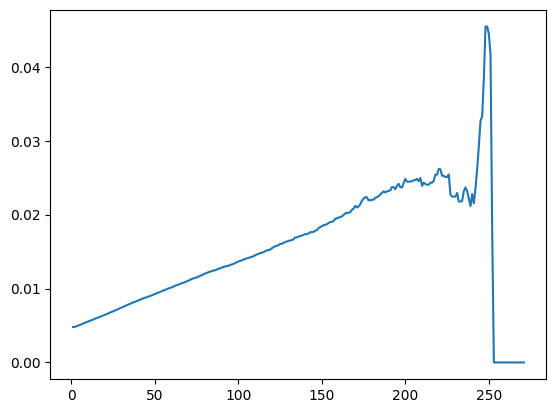

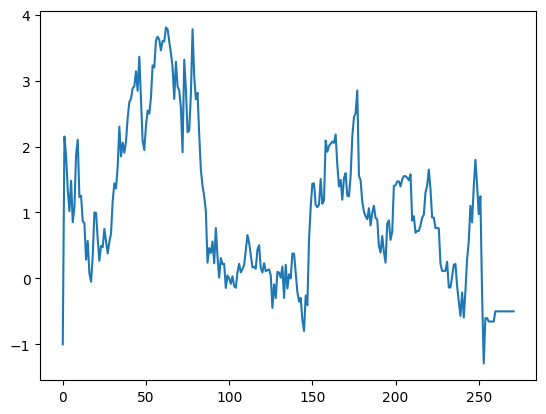

In [47]:
plt.plot(connalysis.network.classic.rich_club_curve(instance1))
plt.figure()
plt.plot(connalysis.network.classic.normalized_rich_club_curve(instance1))

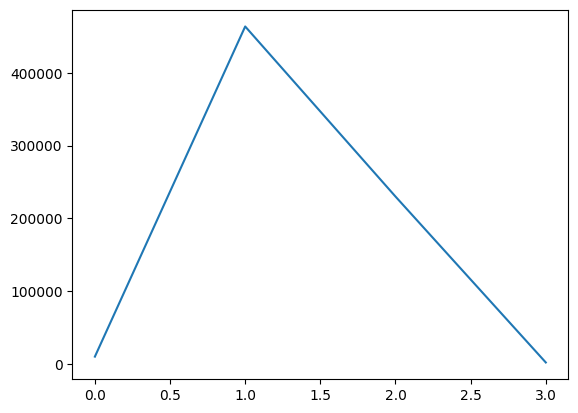

In [48]:
plt.plot(connalysis.network.topology.simplex_counts(instance1, max_dim=8))

p0       0.235571
pttl     0.000970
slope   -0.023146
dtype: float64
P(NN) = 0.412


/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_89670/495729018.py:22: RuntimeWarning: invalid value encountered in divide
  return H_x_con / H_x_all


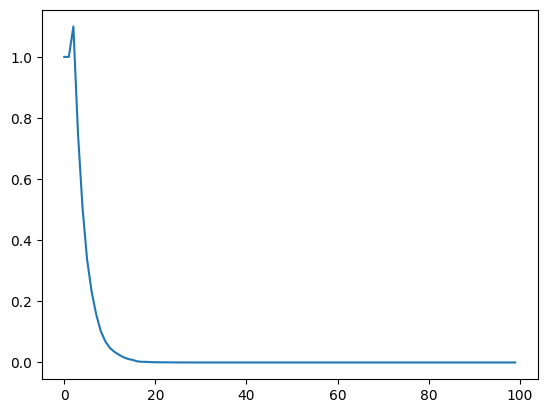

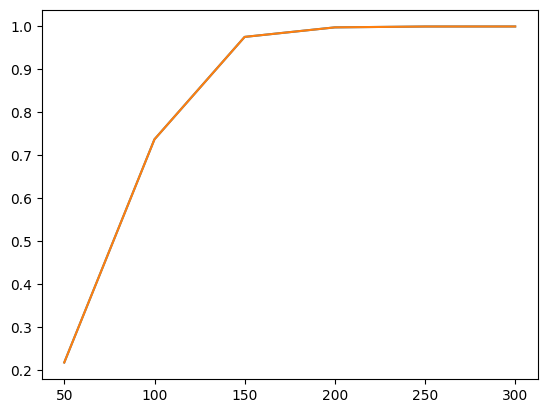

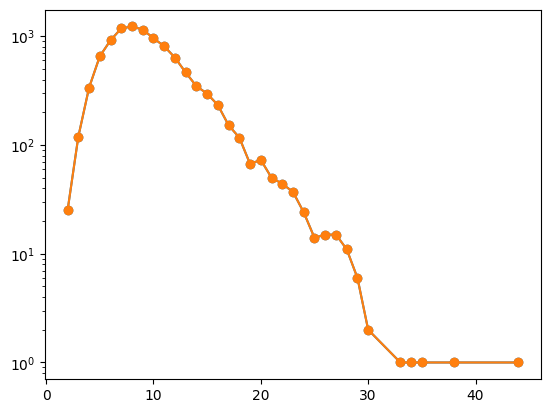

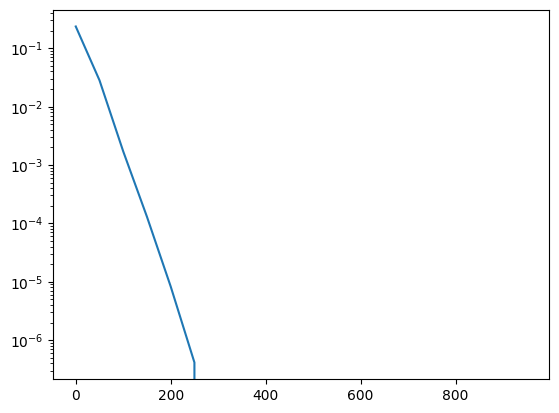

In [30]:
P = [[0.1]]
L = [[10]]
K = [[None]]

N = [10000]
dims = numpy.array([600, 600, 600])
pts = [make_points(dims, _N) for _N in N]

D = squareform(pdist(pts[0]))
nbins = 21
dbins = numpy.linspace(0.01, D.max(), nbins)

M = make_full_matrix(pts, P, L, K=K, mirror=True)
instance1, a, b = build_instance(pts, M, 100, step_tgt=1.1, sum_exclusion=False, n_protected=2)

instance1 = sparse.coo_matrix(numpy.array(instance1.todense()) | numpy.array(instance1.transpose().todense()))
instance1.data = numpy.ones_like(instance1.data, dtype=float)

csr = instance1.tocsr()
H_all = numpy.histogram(D.flatten(), bins=dbins)[0]
H_con = numpy.histogram(D[instance1.row, instance1.col], bins=dbins)[0]

print(instance_distance_dependence(instance1, D, dbins))

_tree = KDTree(pts[0])
_, idx = _tree.query(pts[0], [1, 2])
print("P(NN) = {0}".format(csr[idx[:, 0], idx[:, 1]].mean()))

plt.plot(a)
plt.figure()

nn_ana_e = dist_and_nn_analysis(instance1, pts[0], D, dbins, direction="efferent")
nn_ana_a = dist_and_nn_analysis(instance1, pts[0], D, dbins, direction="afferent")
plt.plot(dbins[1:], (nn_ana_e - (H_con / H_all)) / (nn_ana_e + (H_con / H_all)))
plt.plot(dbins[1:], (nn_ana_a - (H_con / H_all)) / (nn_ana_a + (H_con / H_all)))
plt.figure()

rc = pandas.DataFrame({"row": instance1.tocoo().row,
                       "col": instance1.tocoo().col})
plt.plot(rc["row"].value_counts().value_counts().sort_index(), marker='o')
plt.plot(rc["col"].value_counts().value_counts().sort_index(), marker='o')
plt.gca().set_yscale("log")

# draw_instance_distance_dependence(instance1, D)
plt.figure().gca().plot(dbins[:-1], H_con / H_all)
plt.gca().set_yscale("log")

In [33]:
mn_deg = instance1.sum(axis=1).mean()

p_nn_in = 0.41 # Probability that nn is connected

p_nn_tgt = 0.15

p_nn_tgt * mn_deg / p_nn_in

3.549658536585366

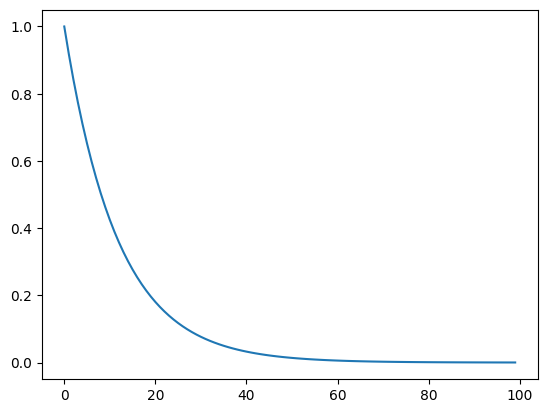

In [35]:
from scipy.stats import poisson

n_steps = numpy.arange(100)

plt.plot(n_steps, (1 - poisson(2.5).pmf(0)) ** n_steps)

p0       0.175669
pttl     0.003723
slope   -0.005027
dtype: float64


<Axes: xlabel='Distance (um)', ylabel='P'>

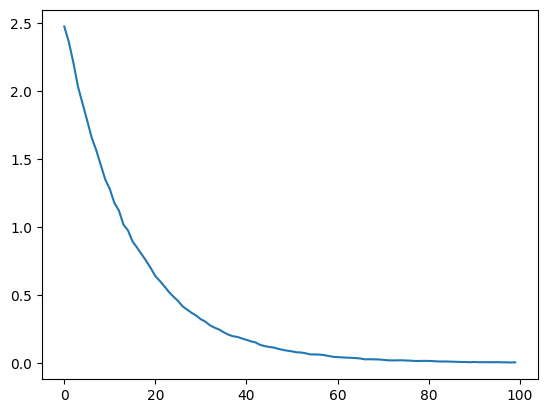

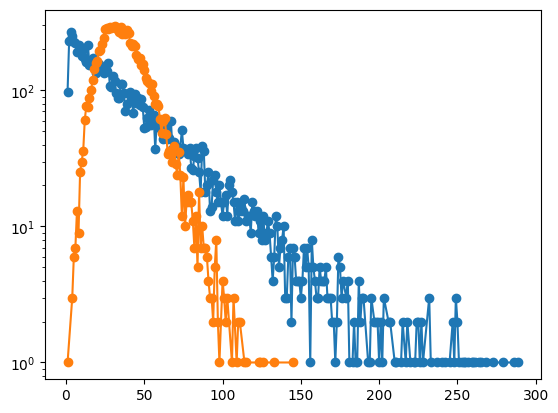

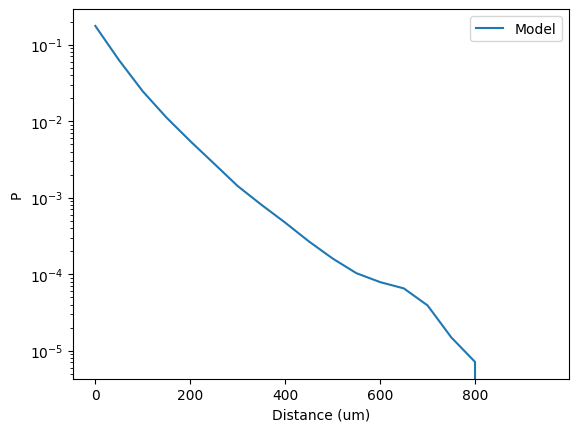

In [34]:

instance2, a, b = build_instance(pts, instance1, 100, step_tgt=2.5, sum_exclusion=True)
print(instance_distance_dependence(instance2, D, dbins))


# plt.plot(dbins[1:], dist_and_nn_analysis(instance2, pts[0], D, dbins, direction="efferent"))
# plt.plot(dbins[1:], dist_and_nn_analysis(instance2, pts[0], D, dbins, direction="afferent"))
plt.plot(a)
plt.figure()

rc = pandas.DataFrame({"row": instance2.tocoo().row,
                       "col": instance2.tocoo().col})
plt.plot(rc["row"].value_counts().value_counts().sort_index(), marker='o')
plt.plot(rc["col"].value_counts().value_counts().sort_index(), marker='o')
plt.gca().set_yscale("log")

draw_instance_distance_dependence(instance2, D)

/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_89670/495729018.py:22: RuntimeWarning: invalid value encountered in divide
  return H_x_con / H_x_all


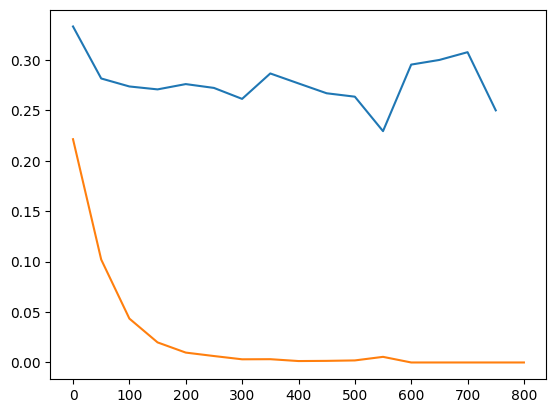

In [36]:
nn_ana_e = dist_and_nn_analysis(instance2, pts[0], D, dbins, direction="efferent")
nn_ana_a = dist_and_nn_analysis(instance2, pts[0], D, dbins, direction="afferent")

plt.plot(dbins[:-1], nn_ana_e)
plt.plot(dbins[:-1], nn_ana_a)

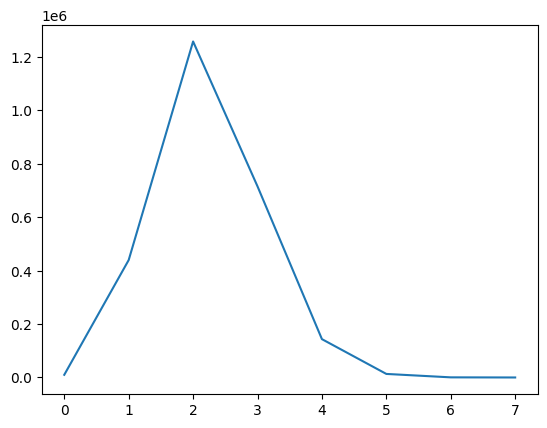

In [24]:
plt.plot(connalysis.network.topology.simplex_counts(instance2, max_dim=8))

/Users/mwr/venvs/connalysis/lib/python3.9/site-packages/connalysis/network/classic.py:305: RuntimeWarning: invalid value encountered in divide
  ret = (np.array([mat_counter(i) for i in udegrees]).astype(float)
/Users/mwr/venvs/connalysis/lib/python3.9/site-packages/connalysis/network/classic.py:350: RuntimeWarning: invalid value encountered in divide
  return pd.Series(cum_degrees / nrn_cum_pairs, degree_bins_rv)[::-1]
/Users/mwr/venvs/connalysis/lib/python3.9/site-packages/connalysis/network/classic.py:422: RuntimeWarning: Mean of empty slice
  "mean": np.nanmean(res, axis=1),
/Users/mwr/venvs/connalysis/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mwr/venvs/connalysis/lib/python3.9/site-packages/connalysis/network/classic.py:447: RuntimeWarning: invalid value encountered in divide
  return pd.Series((B[:len(mn_r)] - mn_r) / sd_r, index=A[:len(mn_r)])

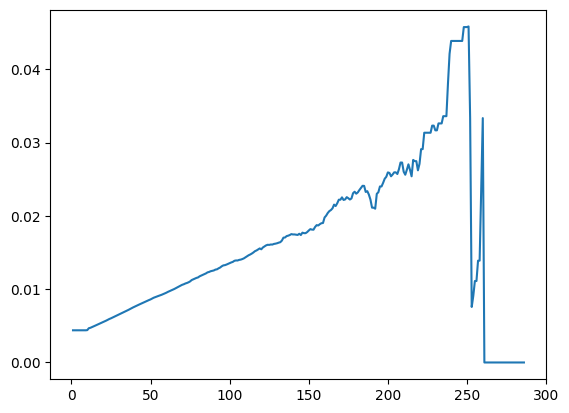

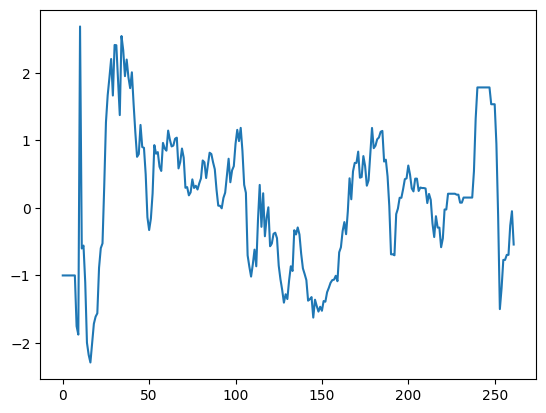

In [39]:
plt.plot(connalysis.network.classic.rich_club_curve(instance2))
plt.figure()
plt.plot(connalysis.network.classic.normalized_rich_club_curve(instance2))

In [127]:
from scipy.stats import binom, poisson

binom(2, 0.5).pmf(0)

0.25

In [154]:
m = sparse.csr_matrix(numpy.random.rand(100, 100) < 0.08) * 0.5

n_pick = numpy.round(numpy.array(m.sum(axis=1))[:, 0]).astype(int)
indptr_out = numpy.hstack([0, numpy.cumsum(n_pick)])

In [155]:
picked = []
for a, b, c in zip(m.indptr[:-1], m.indptr[1:], n_pick):
    picked.append(numpy.random.choice(m.indices[a:b], c, replace=False))
m_out = sparse.csr_matrix((numpy.ones(indptr_out[-1], dtype=bool), 
                           numpy.hstack(picked), indptr_out),
                           shape=m.shape)


In [158]:
n_pick

array([3, 4, 6, 5, 6, 4, 4, 2, 7, 4, 4, 4, 3, 2, 2, 6, 5, 6, 6, 3, 4, 2,
       6, 2, 2, 7, 4, 6, 3, 4, 4, 5, 4, 8, 3, 5, 5, 2, 3, 3, 4, 7, 4, 4,
       5, 2, 8, 2, 2, 4, 2, 4, 4, 2, 4, 2, 6, 4, 3, 5, 3, 4, 4, 4, 5, 4,
       4, 6, 4, 3, 3, 4, 2, 2, 8, 4, 4, 2, 4, 8, 6, 4, 4, 2, 4, 3, 3, 4,
       6, 4, 4, 4, 3, 8, 6, 6, 3, 4, 4, 2])

In [157]:
m_out.sum(axis=1)

matrix([[3],
        [4],
        [6],
        [5],
        [6],
        [4],
        [4],
        [2],
        [7],
        [4],
        [4],
        [4],
        [3],
        [2],
        [2],
        [6],
        [5],
        [6],
        [6],
        [3],
        [4],
        [2],
        [6],
        [2],
        [2],
        [7],
        [4],
        [6],
        [3],
        [4],
        [4],
        [5],
        [4],
        [8],
        [3],
        [5],
        [5],
        [2],
        [3],
        [3],
        [4],
        [7],
        [4],
        [4],
        [5],
        [2],
        [8],
        [2],
        [2],
        [4],
        [2],
        [4],
        [4],
        [2],
        [4],
        [2],
        [6],
        [4],
        [3],
        [5],
        [3],
        [4],
        [4],
        [4],
        [5],
        [4],
        [4],
        [6],
        [4],
        [3],
        [3],
        [4],
        [2],
        [2],
        [8],
        [4],
        [4],

In [148]:
numpy.nonzero(m[0].todense())

(array([0, 0, 0, 0, 0, 0, 0, 0]), array([ 1,  3, 15, 26, 30, 34, 76, 95]))